In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA AND PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [ ]:
path = '/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/phmap_train'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_3rd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_2nd_Unbalance.csv', 'train_2nd_Looseness.csv', 'train_2nd_Bearing.csv']


In [ ]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-130
  #Number_of_data = int((df.shape[0] - time_series_length + 1)/window)
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

### DATA Loading

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/sample_submission_classification.csv')
final = pd.read_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final)

In [ ]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]

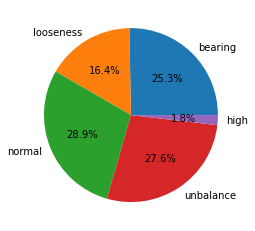

In [ ]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

### Dataset Construction/Augmentation and Solving Class Imabalance Problem

In [ ]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 80)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 487002/487002 [00:28<00:00, 17320.31it/s]


In [ ]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 80)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184373/184373 [00:10<00:00, 17931.35it/s]


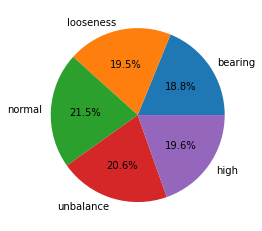

In [ ]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [ ]:
batch_size = 128
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(batch_size).prefetch(1)

In [ ]:
Dataset.__len__().numpy()

19427

In [ ]:
Dataset

<PrefetchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
# Valid_Dataset = Dataset.take(3000) 
# Train_Dataset = Dataset.skip(3000)

In [ ]:
Test_Dataset = test_Dataset.batch(128)

In [ ]:
Valid_Dataset = Dataset.take(15 * batch_size) 
Train_Dataset = Dataset.skip(15 * batch_size)
Train_Dataset = Dataset.take(135 * batch_size)

# VISUALIZATION

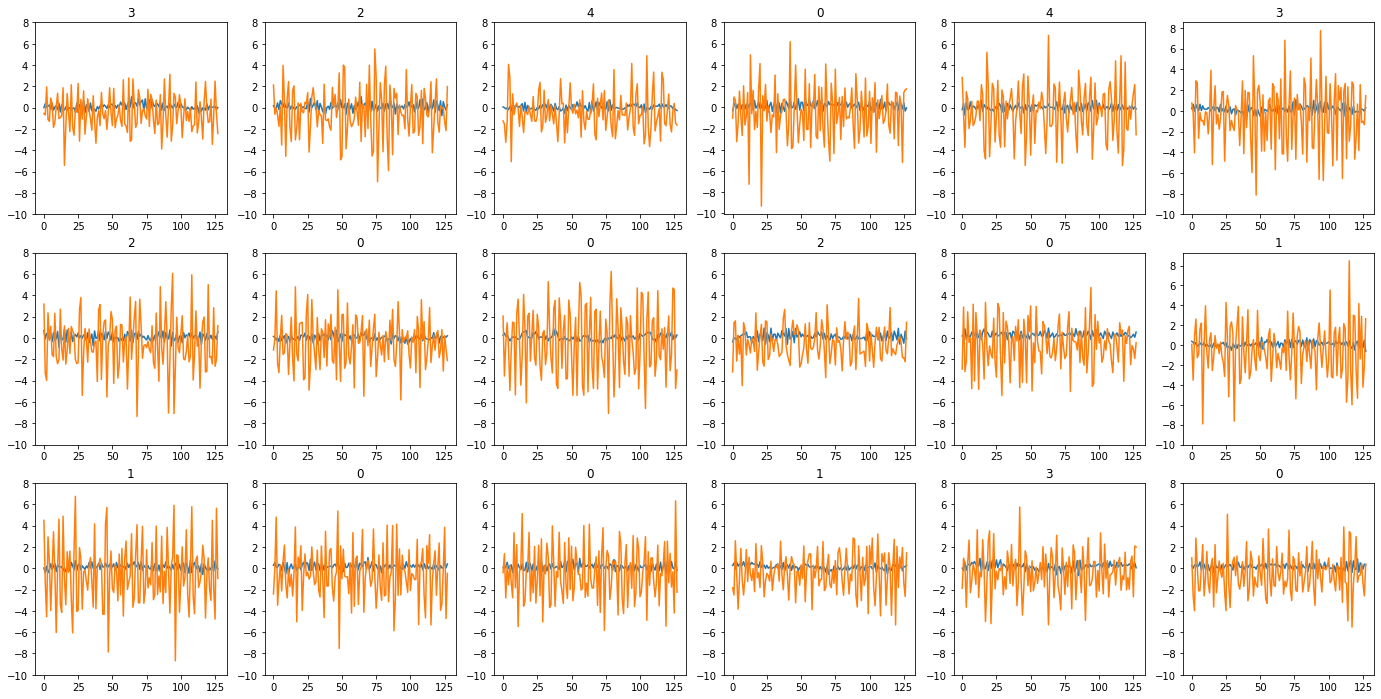

In [ ]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

#Fast Fourier Transform and Continuous Wavelet Transform

In [ ]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[0][0]

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

In [ ]:
import  pywt
from scipy import fftpack

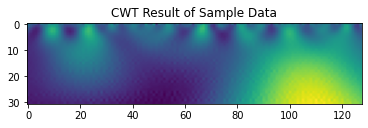

In [ ]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

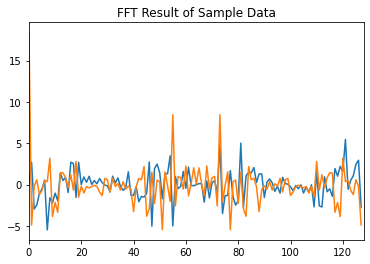

In [ ]:
# https://sdc-james.gitbook.io/onebook/4.-numpy-and-scipy/4.3-scipy/4.3.3.-fast-fourier-transforms-scipy.fftpack

imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

#CUSTOM MODELING 1 (BASIC) _ F1 0.9365

In [ ]:
CUSTOM_MODEL1 = keras.models.Sequential([
        #keras.layers.LSTM(16, input_shape=(128,2), activation='relu'),
        keras.layers.Flatten(input_shape=(128,2)),
        keras.layers.Dense(16, activation = 'relu'),
        keras.layers.Dense(8, activation = 'relu'),
        keras.layers.Dense(5, activation = 'softmax'),
])

CUSTOM_MODEL1.summary()

CUSTOM_MODEL1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?


history = CUSTOM_MODEL1.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 45        
Total params: 4,293
Trainable params: 4,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16007/16007 [==============================] - 45s 3ms/step - loss: 0.4664 - accuracy: 0.8191 - val_loss: 0.1710 - val_accuracy: 0.9416
Epoch 2/10
16007/16007 [==============================] - 45s 3ms/step - loss: 0.1281 - accuracy: 0.957

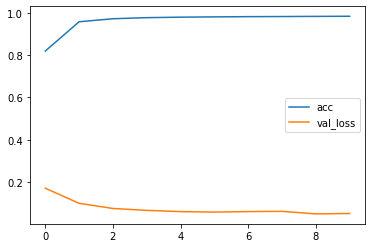

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f138a6b1e10>]],
      dtype=object)

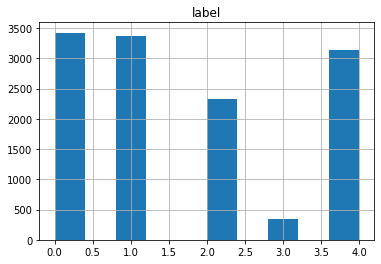

In [ ]:
pred=CUSTOM_MODEL1.predict(Test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL1.csv', index = False)
sub.hist()

# CUSTOM MODELING 2 (STFT, CNN) _ F1 0.9898

In [ ]:
def tf_stft(series_t):
  spectro = tf.signal.stft(series_t, frame_length = 32, frame_step = 8)
  return spectro

def tf_reshape_stft(series, label):
  series_t = tf.transpose(series)
  spectros1 = tf.expand_dims(tf_stft(series_t[0]), axis=-1)
  spectros2 = tf.expand_dims(tf_stft(series_t[1]), axis=-1)
  spectros = tf.concat([spectros1, spectros2], axis = -1)
  spectros = tf.abs(spectros)
  return spectros, label

In [ ]:
Train_Dataset_stft = Train_Dataset.unbatch().map(tf_reshape_stft).batch(128)
Valid_Dataset_stft = Valid_Dataset.unbatch().map(tf_reshape_stft).batch(128)
Test_Dataset_stft = Test_Dataset.unbatch().map(tf_reshape_stft).batch(128)

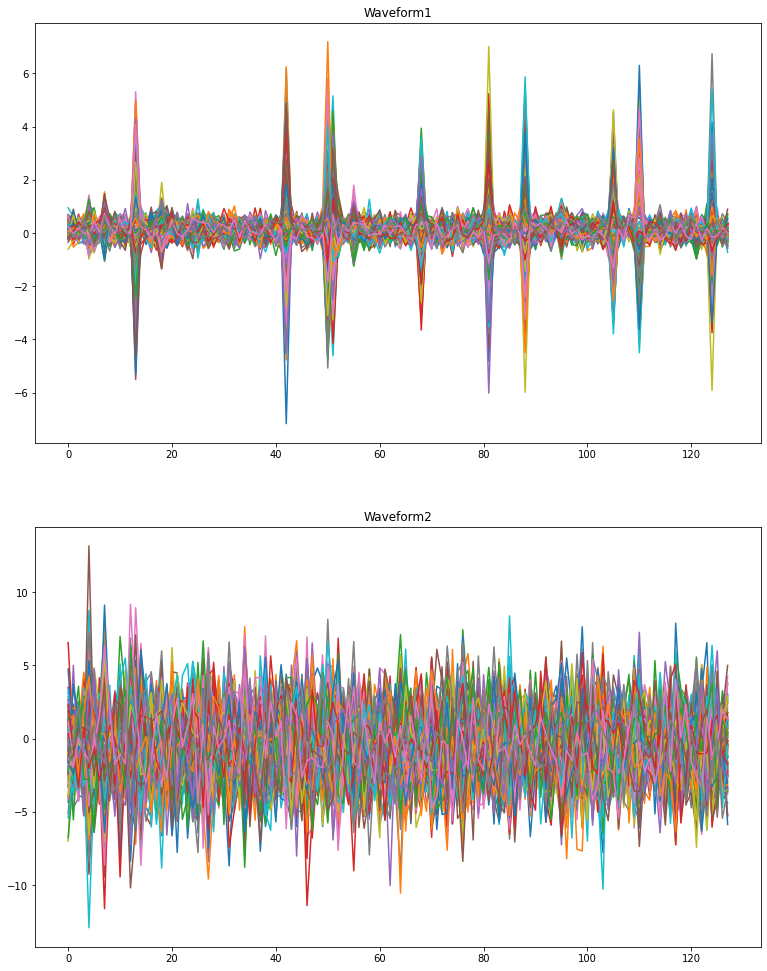

In [ ]:
for ser, lable in Train_Dataset.take(1):
  fig, axes = plt.subplots(2, figsize=(13, 17))
  timescale = np.arange(ser.shape[0])
  axes[0].plot(timescale, ser[:,:,0].numpy())
  axes[0].set_title('Waveform1')
  axes[1].plot(timescale, ser[:,:,1].numpy())
  axes[1].set_title('Waveform2')
  plt.show()

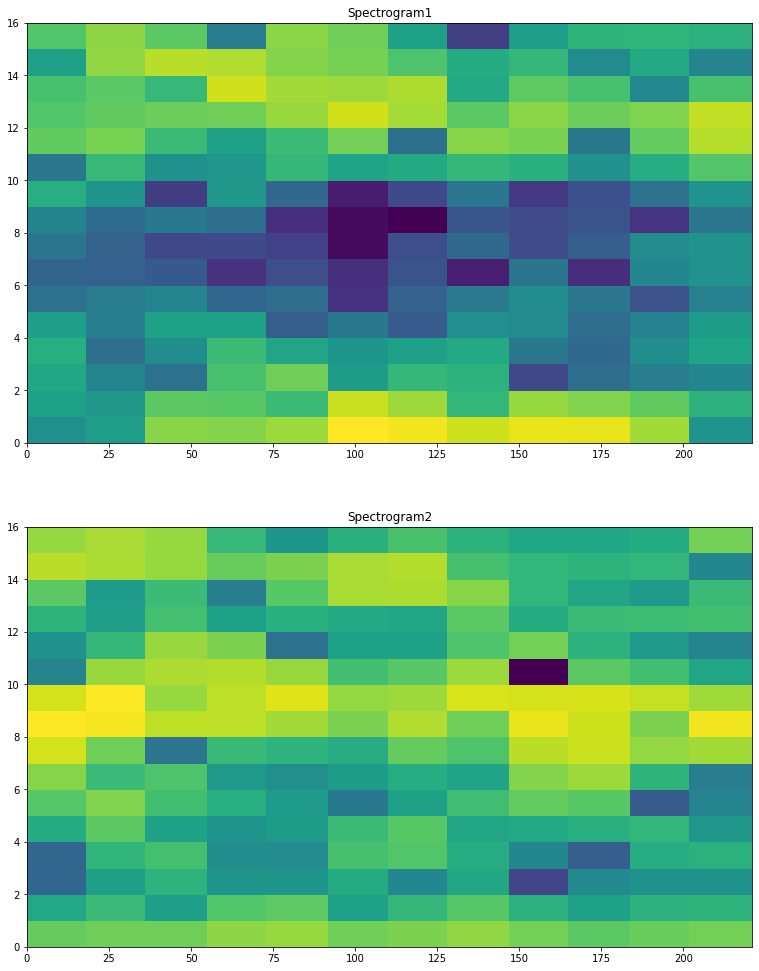

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

for spec, lable in d.take(1):
  fig, axes = plt.subplots(2, figsize=(13, 17))
  plot_spectrogram(spec[:,:,0].numpy(), axes[0])
  axes[0].set_title('Spectrogram1')
  plot_spectrogram(spec[:,:,1].numpy(), axes[1])
  axes[1].set_title('Spectrogram2')
  plt.show()

In [ ]:
Train_Dataset_stft

<BatchDataset shapes: ((None, 13, 17, 2), (None,)), types: (tf.float64, tf.float64)>

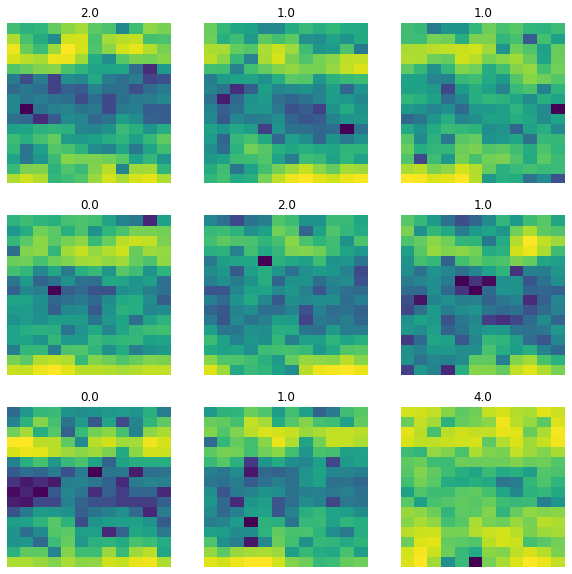

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(Train_Dataset_stft.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram[:,:,0].numpy()), ax)
  ax.set_title(label_id.numpy())
  ax.axis('off')

plt.show()

In [ ]:
CUSTOM_MODEL2 = keras.models.Sequential([
        keras.layers.Conv2D(12, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2)),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2)),
        keras.layers.MaxPool2D(pool_size = (2,2)),        
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dense(16, activation = 'relu'),
        keras.layers.Dense(5, activation = 'softmax'),
])

CUSTOM_MODEL2.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)

CUSTOM_MODEL2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?


history = CUSTOM_MODEL2.fit(Train_Dataset_stft, epochs = 3, shuffle = True, validation_data = Valid_Dataset_stft)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 13, 17, 12)        228       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 8, 12)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 8, 16)          1744      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 4, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_19 (Dense)             (None, 16)               

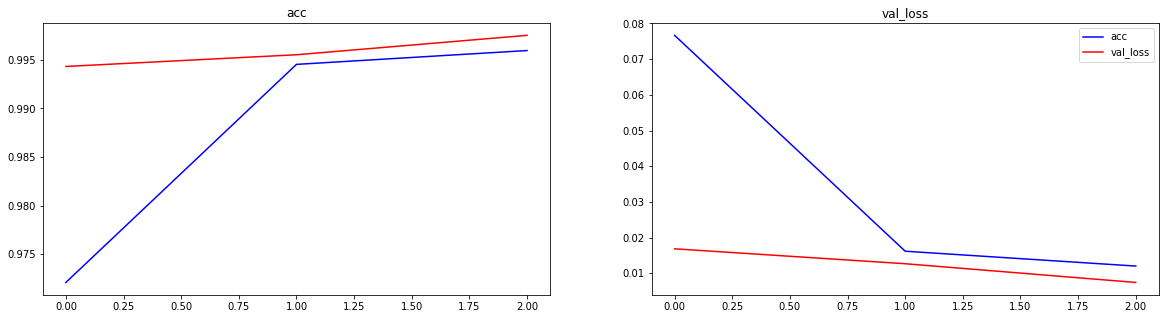

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['accuracy'], c = 'b')
ax1.plot(history.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['loss'], c = 'b')
ax2.plot(history.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e1193410>]],
      dtype=object)

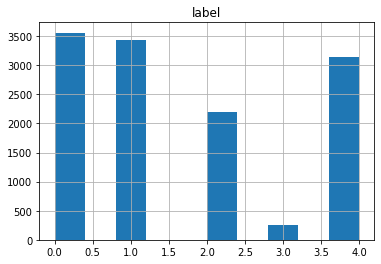

In [ ]:
pred=CUSTOM_MODEL2.predict(Test_Dataset_stft)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL2.csv', index = False)
sub.hist()

# CUSTOM MODELING 2 +

In [ ]:
def tf_stft(series_t):
  spectro = tf.signal.stft(series_t, frame_length = 32, frame_step = 8)
  return spectro

def tf_reshape_stft(series, label):
  series_t = tf.transpose(series)
  spectros1 = tf.expand_dims(tf_stft(series_t[0]), axis=-1)
  spectros2 = tf.expand_dims(tf_stft(series_t[1]), axis=-1)
  spectros = tf.concat([spectros1, spectros2], axis = -1)
  spectros = tf.abs(spectros)
  return spectros, label

In [ ]:
Train_Dataset_stft = Train_Dataset.unbatch().map(tf_reshape_stft).batch(128)
Valid_Dataset_stft = Valid_Dataset.unbatch().map(tf_reshape_stft).batch(128)
Test_Dataset_stft = Test_Dataset.unbatch().map(tf_reshape_stft).batch(128)

In [ ]:
CUSTOM_MODEL2 = keras.models.Sequential([
        keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'),
        keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'), 
        keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'),
        tf.keras.layers.Reshape((-1, 128)),
        keras.layers.LSTM(64, activation = 'relu'),       
        keras.layers.Dense(32, activation = 'relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation = 'relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(5, activation = 'softmax'),
])

CUSTOM_MODEL2.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)

CUSTOM_MODEL2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?


history = CUSTOM_MODEL2.fit(Train_Dataset_stft, epochs = 3, shuffle = True, validation_data = Valid_Dataset_stft)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 13, 17, 16)        304       
_________________________________________________________________
batch_normalization_87 (Batc (None, 13, 17, 16)        64        
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 7, 9, 16)          0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 9, 64)          9280      
_________________________________________________________________
batch_normalization_88 (Batc (None, 7, 9, 64)          256       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 4, 5, 64)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 4, 5, 128)       

In [ ]:
history = CUSTOM_MODEL2.fit(Train_Dataset_stft, epochs = 3, shuffle = True, validation_data = Valid_Dataset_stft)

Epoch 1/3
16007/16007 [==============================] - 336s 21ms/step - loss: 0.0778 - accuracy: 0.9775 - val_loss: 0.0068 - val_accuracy: 0.9982
Epoch 2/3
16007/16007 [==============================] - 336s 21ms/step - loss: 0.0794 - accuracy: 0.9773 - val_loss: 0.0100 - val_accuracy: 0.9982
Epoch 3/3
16005/16007 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9782

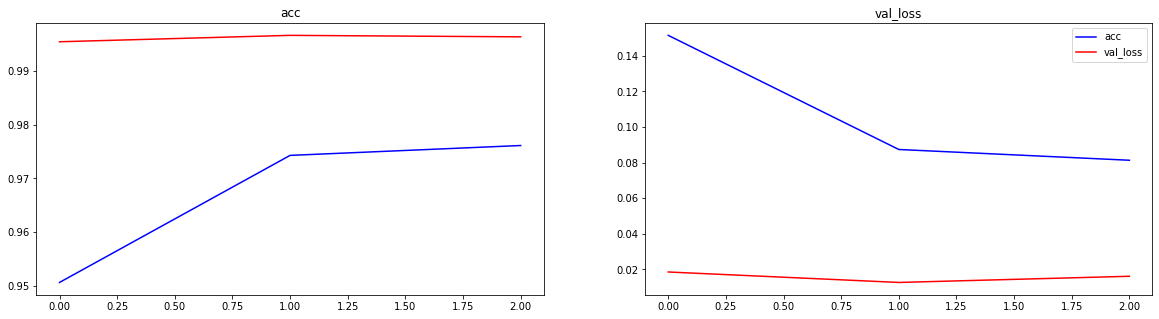

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['accuracy'], c = 'b')
ax1.plot(history.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['loss'], c = 'b')
ax2.plot(history.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e1193410>]],
      dtype=object)

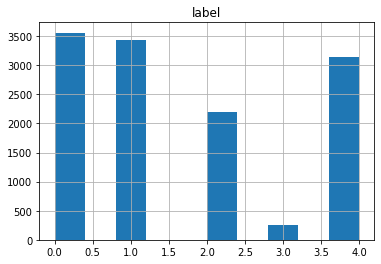

In [ ]:
pred=CUSTOM_MODEL2.predict(Test_Dataset_stft)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL2.csv', index = False)
sub.hist()

# CUSTOM MODELING 3 (CLSTM)

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]

Layer

In [ ]:
class DynFeatures_RealFFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_RealFFT, self).__init__()

  def call(self, inputs):
    fft = tf.signal.fft(tf.cast(inputs, tf.complex64))
    return tf.math.real(fft)

class DynFeatures_ImagFFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_ImagFFT, self).__init__()

  def call(self, inputs):
    fft = tf.signal.fft(tf.cast(inputs, tf.complex64))
    return tf.math.imag(fft)

class DynFeatures_STFT(keras.layers.Layer):
  def __init__(self):
    super(DynFeatures_STFT, self).__init__()
    
  def call(self, inputs):
    stft1 = tf.expand_dims(tf.signal.stft(inputs[:, :, 0], frame_length = 32, frame_step = 8), axis=-1)
    stft2 = tf.expand_dims(tf.signal.stft(inputs[:, :, 1], frame_length = 32, frame_step = 8), axis=-1)
    stft = tf.concat([stft1, stft2], axis = -1)
    stft = tf.abs(stft)
    return stft

class Statistical_Analysis(keras.layers.Layer):
  # mean, max, min, rms // variance, skewness, kurtosis // crest factor, impulse factor, shape factor
  def __init__(self, length_of_signal = 128):
    super(Statistical_Analysis, self).__init__()
    self.length_of_signal = length_of_signal

  def call(self, inputs):
    mean = tf.expand_dims(tf.math.reduce_mean(inputs, axis = 1), axis = 1)
    max = tf.expand_dims(tf.math.reduce_max(inputs, axis = 1), axis = 1)
    min = tf.expand_dims(tf.math.reduce_min(inputs, axis = 1), axis = 1)
    rms = tf.expand_dims(tf.math.sqrt(tf.math.divide(tf.reduce_sum(tf.pow(inputs, 2), axis = 1), self.length_of_signal)), axis = 1)
    var = tf.expand_dims(tf.math.reduce_variance(inputs, axis = 1), axis = 1)
    #skew = tf.math.multiply(self.length_of_signal/((self.length_of_signal - 1)*(self.length_of_signal - 2)), tf.expand_dims(tf.reduce_sum(tf.pow(tf.math.divide(tf.subtract(inputs, tf.expand_dims(tf.reduce_mean(inputs, axis = 1), axis = 1)), tf.math.reduce_std(inputs,axis = 1)), 3), axis = 1), axis = 1))

    #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
    #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
    #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
    #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
    #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)

    stat = tf.concat([max, min, mean, rms, var], axis = 1)
    return stat

Model

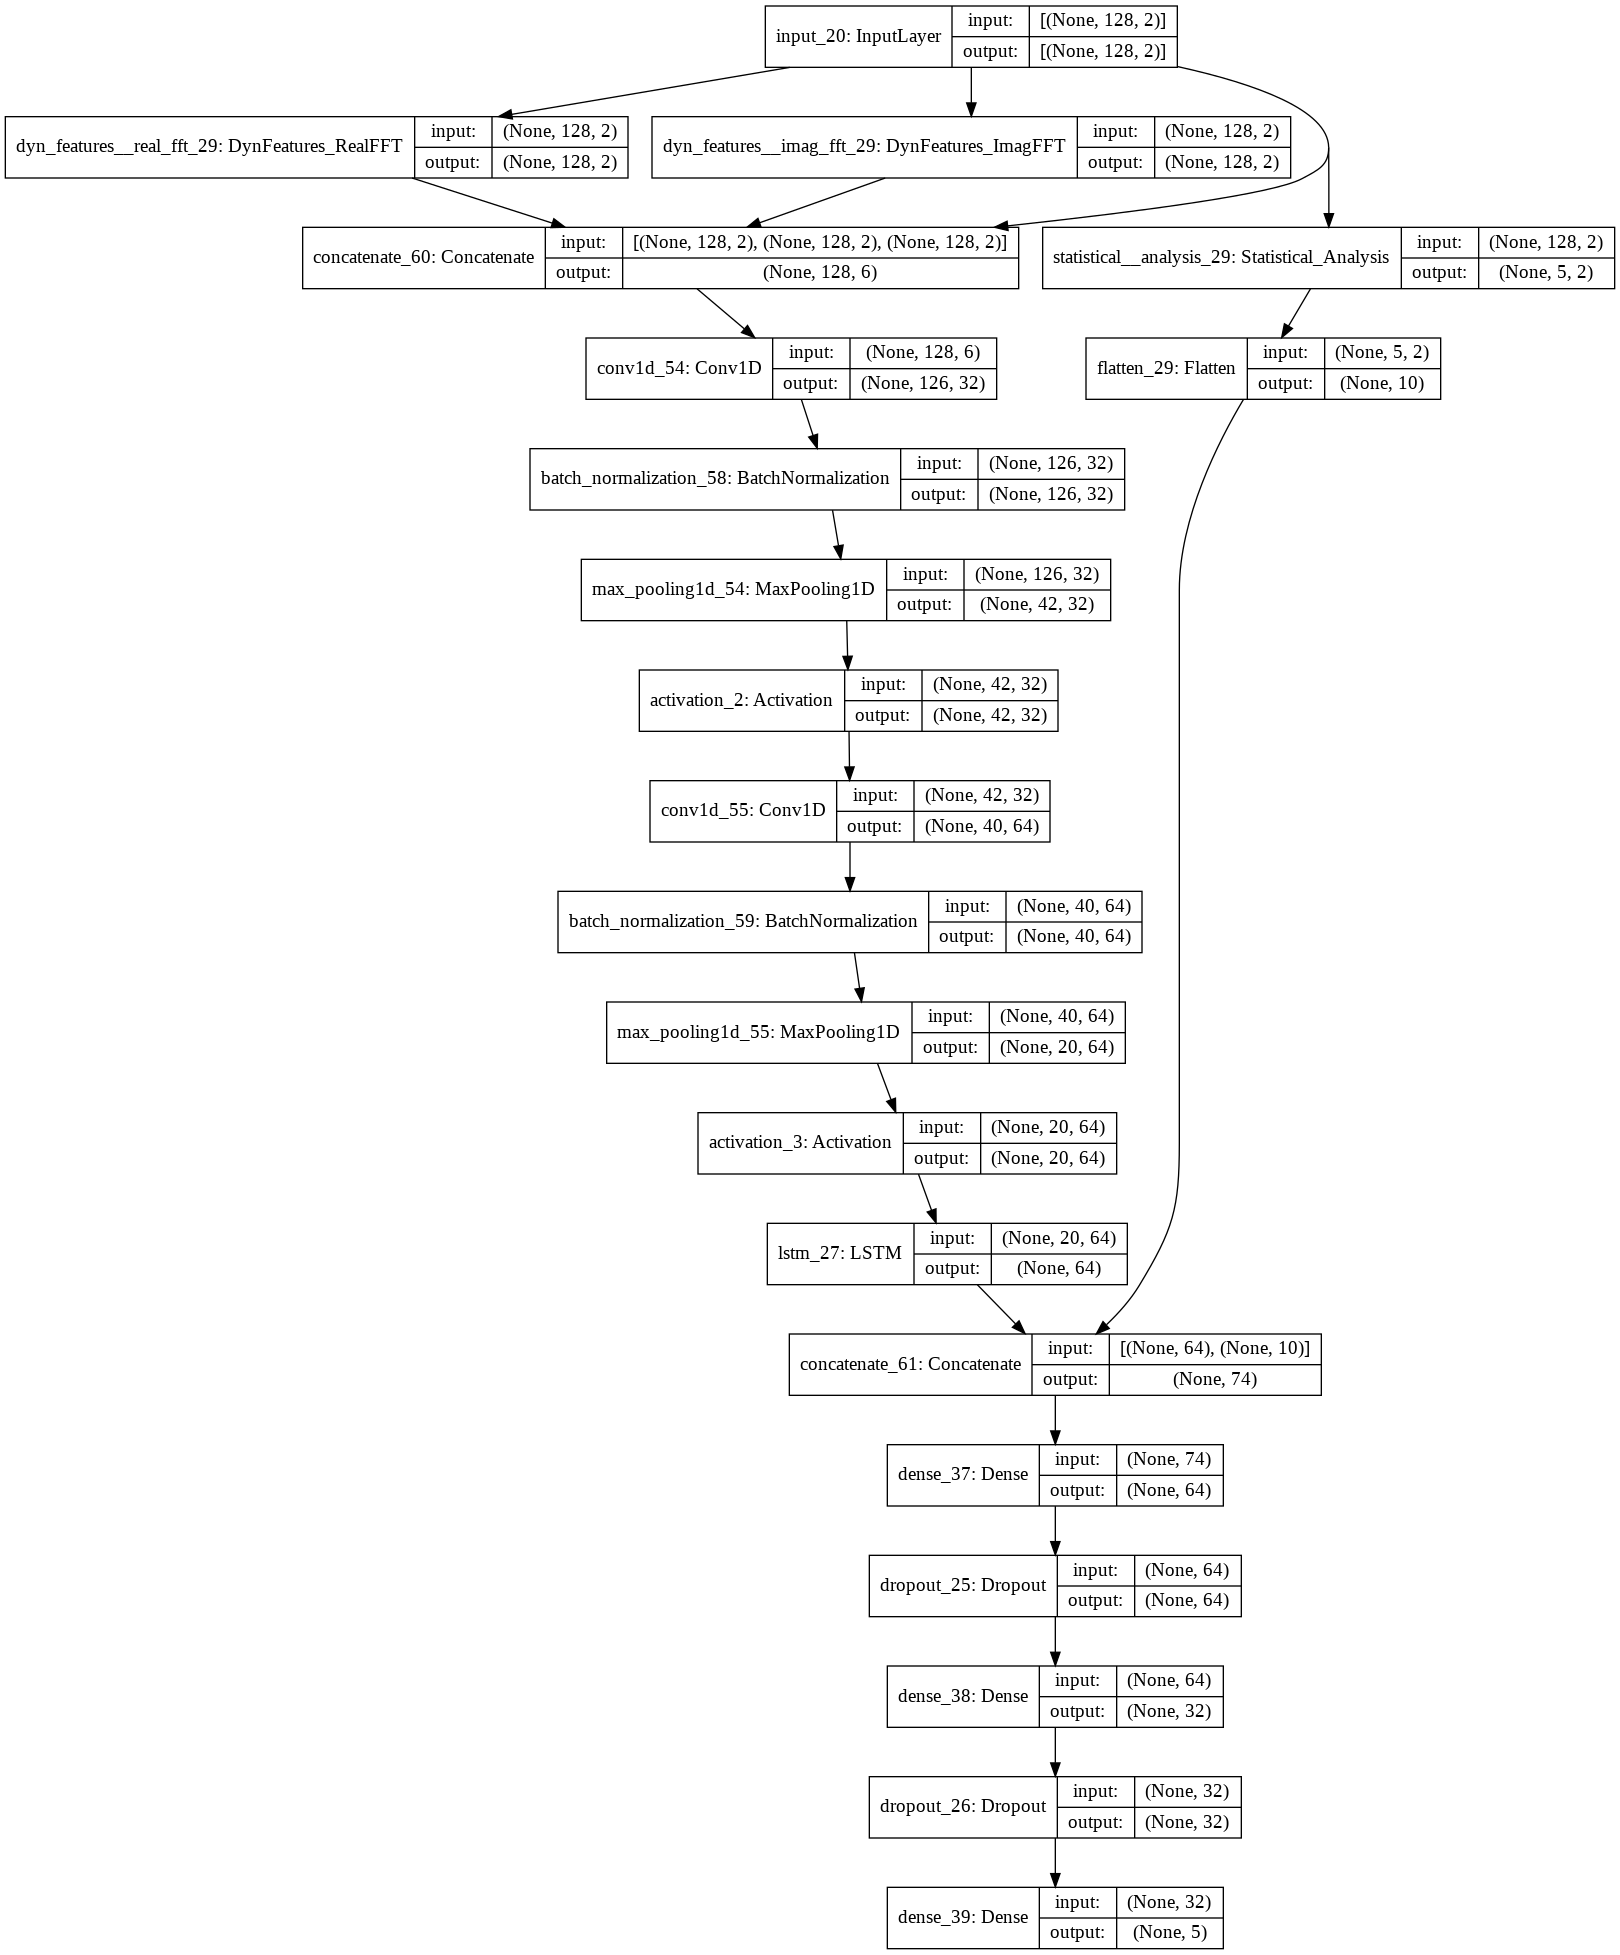

In [ ]:
def CLSTM():
  input = keras.Input(shape = (128,2))
  r = DynFeatures_RealFFT()(input)
  i = DynFeatures_ImagFFT()(input)
  d = keras.layers.Concatenate()([input, r, i])
  s = Statistical_Analysis()(input)
  s = keras.layers.Flatten()(s)

  y1 = keras.layers.Conv1D(32, 3)(d)
  y1 = keras.layers.BatchNormalization()(y1)
  y1 = keras.layers.MaxPool1D(3)(y1)
  y1 = keras.layers.Activation('relu')(y1)
  y1 = keras.layers.Conv1D(64, 3)(y1)
  y1 = keras.layers.BatchNormalization()(y1)
  y1 = keras.layers.MaxPool1D(2)(y1)
  y1 = keras.layers.Activation('relu')(y1)
  y1 = keras.layers.LSTM(64)(y1)
  
  y = keras.layers.Concatenate()([y1, s])
  y = keras.layers.Dense(64)(y)
  y = keras.layers.Dropout(0.5)(y)
  y = keras.layers.Dense(32)(y)
  y = keras.layers.Dropout(0.5)(y)
  y = keras.layers.Dense(5, activation = "softmax")(y)

  model = keras.Model(input, y)
  return model

model = CLSTM()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dyn_features__real_fft_29 (DynF (None, 128, 2)       0           input_20[0][0]                   
__________________________________________________________________________________________________
dyn_features__imag_fft_29 (DynF (None, 128, 2)       0           input_20[0][0]                   
__________________________________________________________________________________________________
concatenate_60 (Concatenate)    (None, 128, 6)       0           input_20[0][0]                   
                                                                 dyn_features__real_fft_29[

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(Train_Dataset, epochs = 50, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/50
17280/17280 [==============================] - 128s 7ms/step - loss: 0.0553 - accuracy: 0.9828 - val_loss: 0.2017 - val_accuracy: 0.9562
Epoch 2/50
17280/17280 [==============================] - 126s 7ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.0671 - val_accuracy: 0.9859
Epoch 3/50
17280/17280 [==============================] - 125s 7ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.0025 - val_accuracy: 0.9992
Epoch 4/50
17280/17280 [==============================] - 126s 7ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0256 - val_accuracy: 0.9937
Epoch 5/50
17280/17280 [==============================] - 125s 7ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.0035 - val_accuracy: 0.9990
Epoch 6/50
17280/17280 [==============================] - 126s 7ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 7/50
17280/17280 [==============================] - 125s 7ms/step - loss: 0.0045 - accuracy: 0.9988 - val_

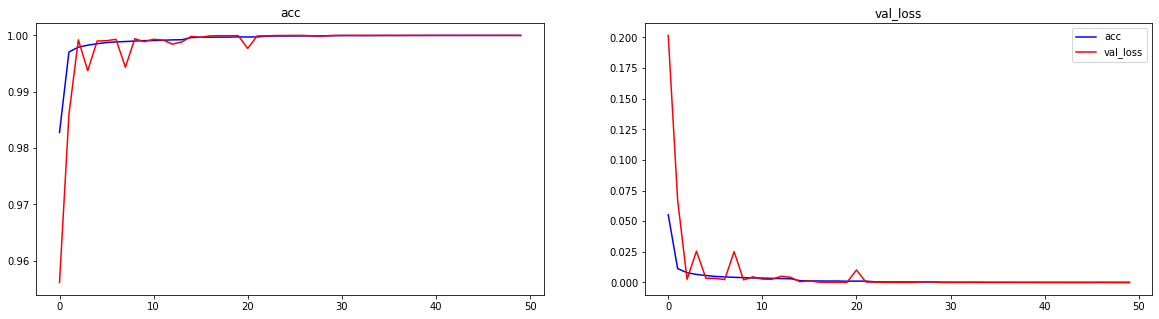

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hist.history['accuracy'], c = 'b')
ax1.plot(hist.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(hist.history['loss'], c = 'b')
ax2.plot(hist.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1183b1d9d0>]],
      dtype=object)

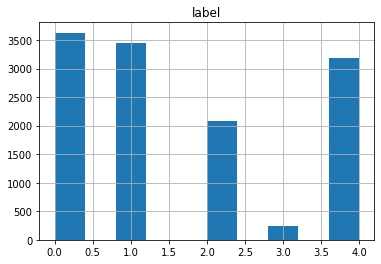

In [ ]:
pred=model.predict(Test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL3.csv', index = False)
sub.hist()

# CUSTOM_MODELING 4(CLSTM_with_STFT)

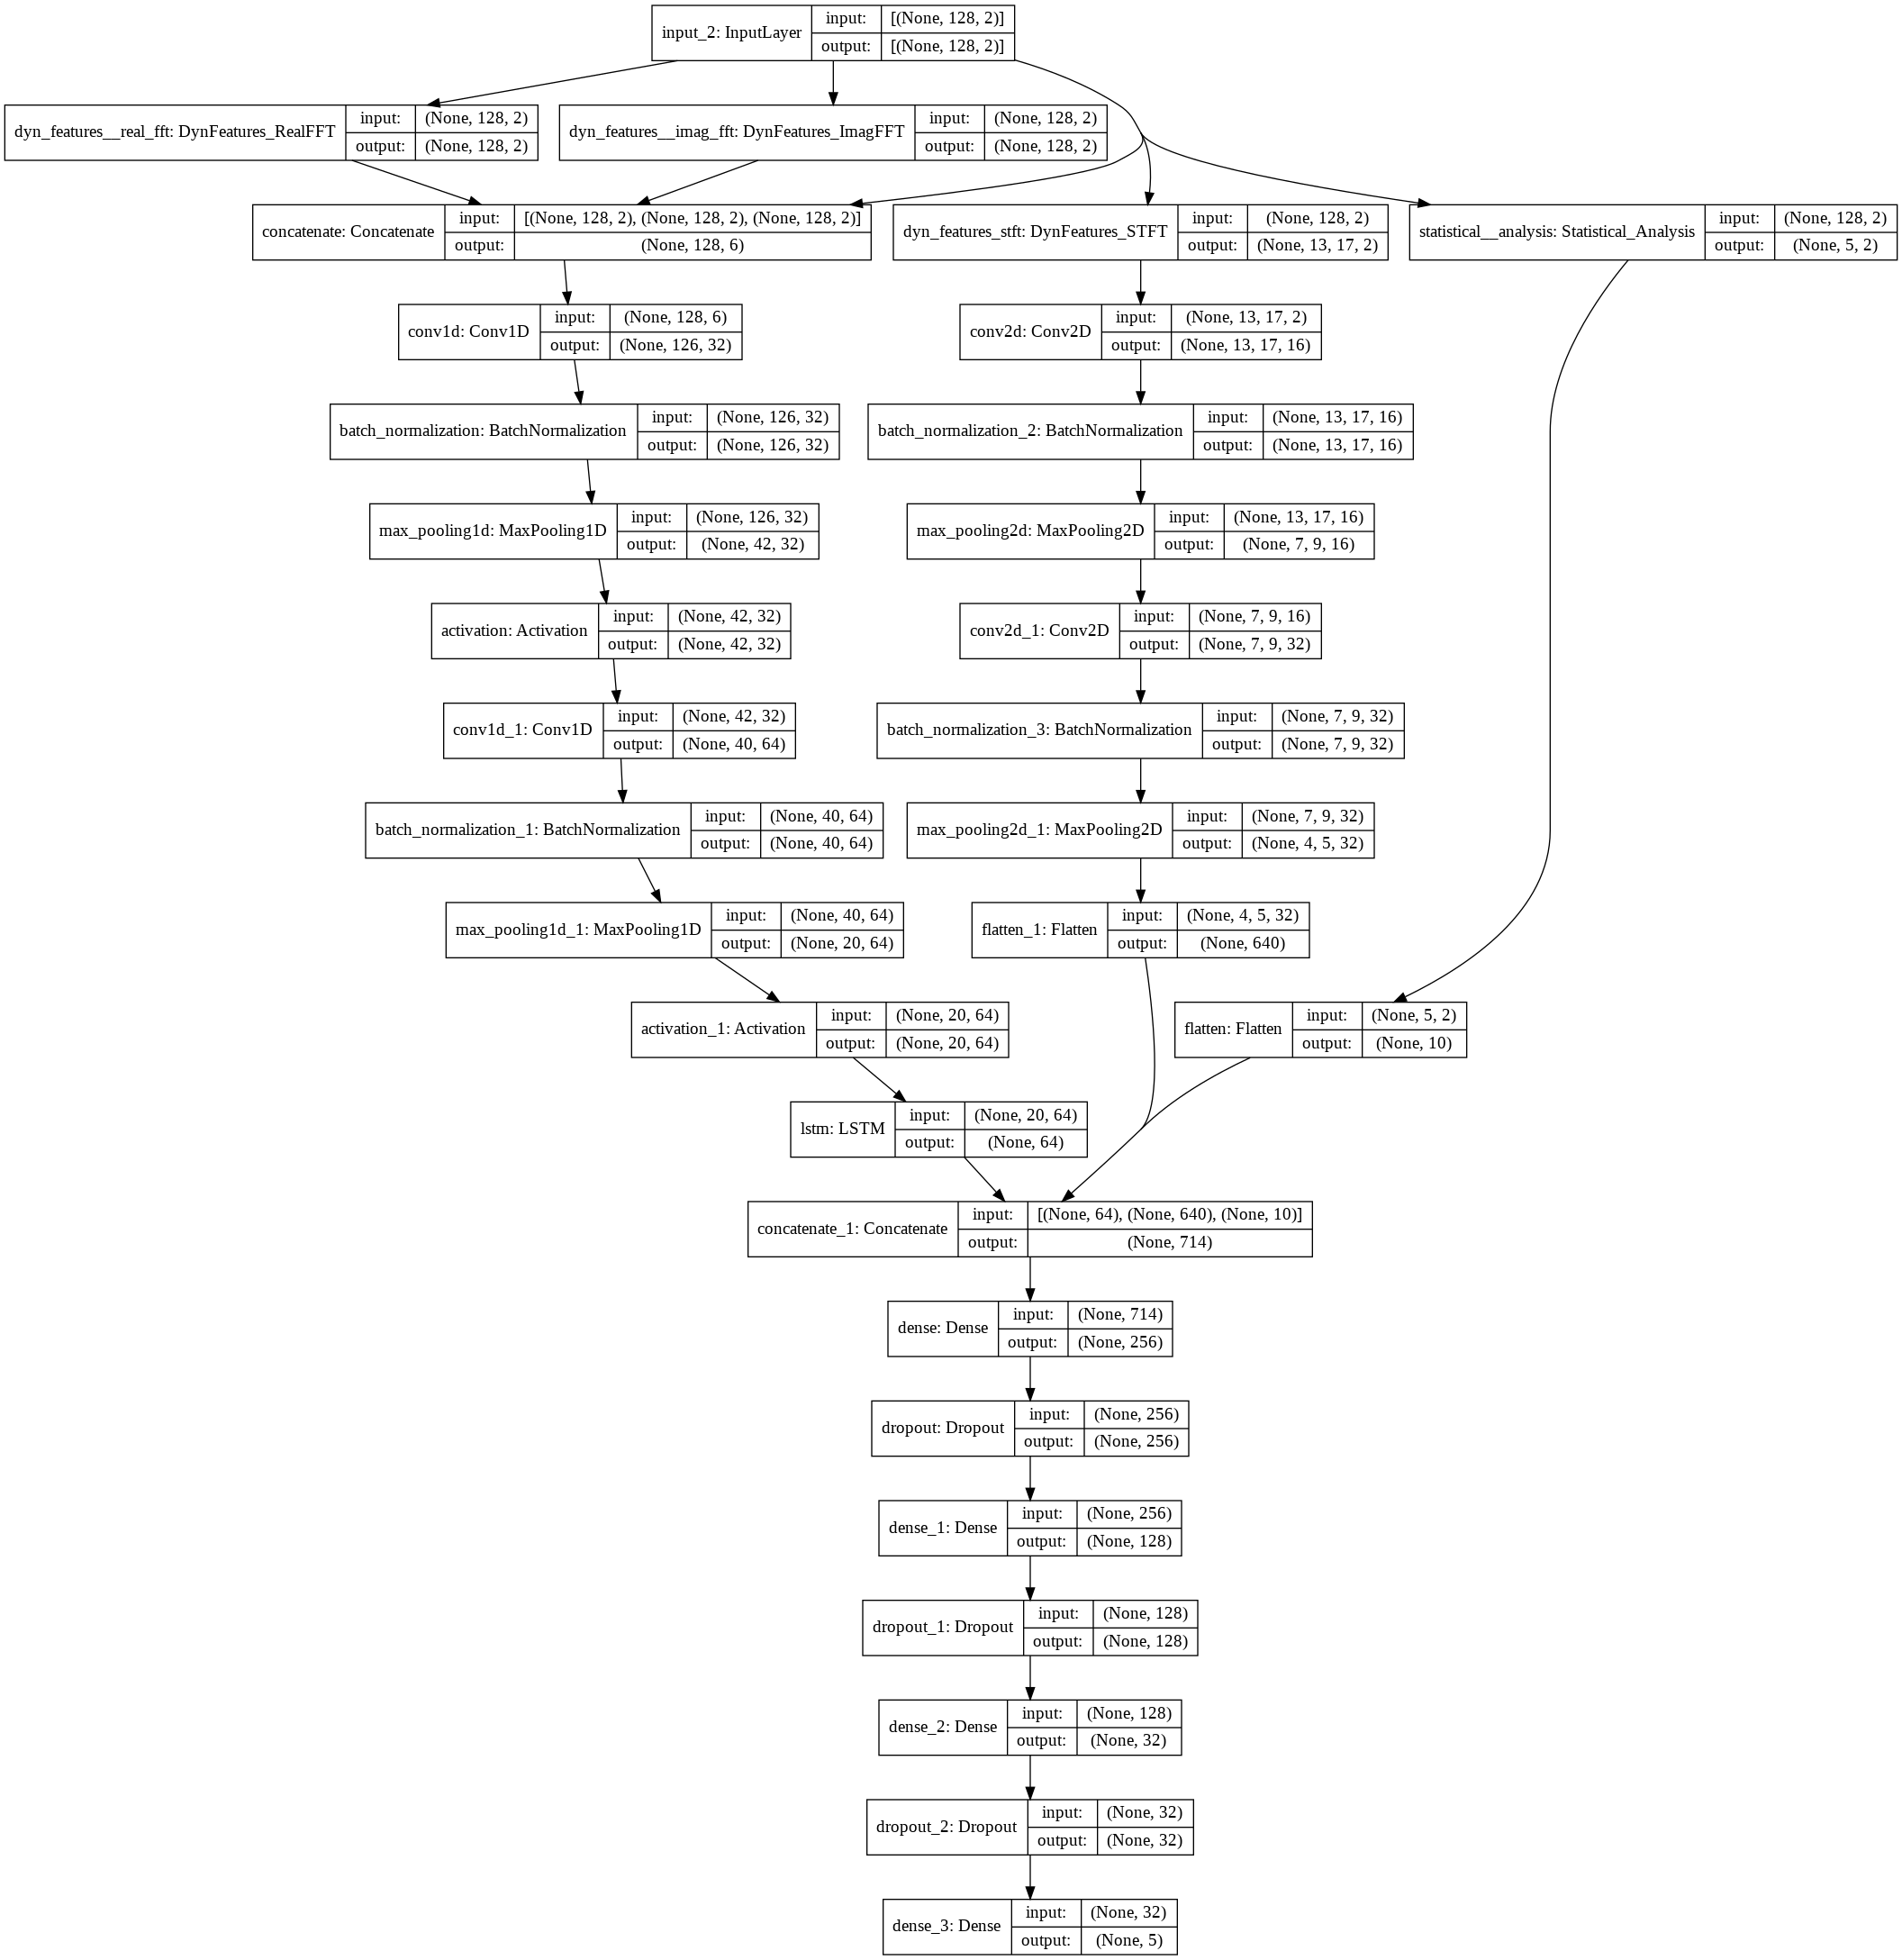

In [ ]:
def CLSTM_with_STFT():
  input = keras.Input(shape = (128,2))
  r = DynFeatures_RealFFT()(input)
  i = DynFeatures_ImagFFT()(input)
  d = keras.layers.Concatenate()([input, r, i])
  s = Statistical_Analysis()(input)
  s = keras.layers.Flatten()(s)

  stft = DynFeatures_STFT()(input)

  # Dyn1
  y1 = keras.layers.Conv1D(32, 3)(d)
  y1 = keras.layers.BatchNormalization()(y1)
  y1 = keras.layers.MaxPool1D(3)(y1)
  y1 = keras.layers.Activation('relu')(y1)
  y1 = keras.layers.Conv1D(64, 3)(y1)
  y1 = keras.layers.BatchNormalization()(y1)
  y1 = keras.layers.MaxPool1D(2)(y1)
  y1 = keras.layers.Activation('relu')(y1)
  y1 = keras.layers.LSTM(64)(y1)

  # Dyn2
  y2 = keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(stft)
  y2 = keras.layers.BatchNormalization()(y2)
  y2 = keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same')(y2)
  y2 = keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu')(y2)
  y2 = keras.layers.BatchNormalization()(y2)
  y2 = keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same')(y2)
  y2 = keras.layers.Flatten()(y2)

  # Concatenate
  y = keras.layers.Concatenate()([y1, y2, s])
  y = keras.layers.Dense(256, activation = "relu")(y)
  y = keras.layers.Dropout(0.5)(y)
  y = keras.layers.Dense(128, activation = "relu")(y)
  y = keras.layers.Dropout(0.5)(y)
  y = keras.layers.Dense(32, activation = "relu")(y)
  y = keras.layers.Dropout(0.5)(y)
  y = keras.layers.Dense(5, activation = "softmax")(y)

  model = keras.Model(input, y)
  return model

model = CLSTM_with_STFT()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dyn_features__real_fft (DynFeat (None, 128, 2)       0           input_2[0][0]                    
__________________________________________________________________________________________________
dyn_features__imag_fft (DynFeat (None, 128, 2)       0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 6)       0           input_2[0][0]                    
                                                                 dyn_features__real_fft[0][0] 

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(Train_Dataset, epochs = 50, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/50
17280/17280 [==============================] - 171s 9ms/step - loss: 0.0834 - accuracy: 0.9726 - val_loss: 0.0442 - val_accuracy: 0.9884
Epoch 2/50
17280/17280 [==============================] - 150s 9ms/step - loss: 0.0206 - accuracy: 0.9946 - val_loss: 0.0052 - val_accuracy: 0.9985
Epoch 3/50
17280/17280 [==============================] - 150s 9ms/step - loss: 0.0161 - accuracy: 0.9958 - val_loss: 0.0149 - val_accuracy: 0.9962
Epoch 4/50
17280/17280 [==============================] - 149s 8ms/step - loss: 0.0135 - accuracy: 0.9966 - val_loss: 0.0065 - val_accuracy: 0.9983
Epoch 5/50
17280/17280 [==============================] - 147s 8ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.0032 - val_accuracy: 0.9991
Epoch 6/50
17280/17280 [==============================] - 147s 8ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 7/50
17280/17280 [==============================] - 146s 8ms/step - loss: 0.0108 - accuracy: 0.9973 - val_

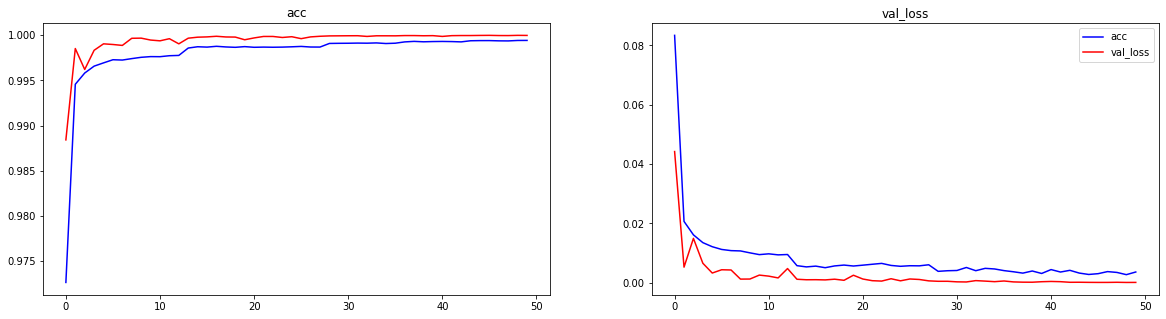

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hist.history['accuracy'], c = 'b')
ax1.plot(hist.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(hist.history['loss'], c = 'b')
ax2.plot(hist.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5ebeb1b10>]],
      dtype=object)

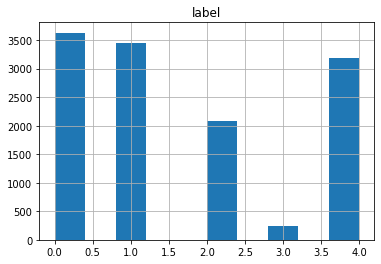

In [ ]:
pred=model.predict(Test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL4.csv', index = False)
sub.hist()

# CUSTOM_MODELING 4(CLSTM_with_VTL)

In [ ]:
class CLSTM_Basic(keras.Model):
  def __init__(self, time_length = 128):
    super(CLSTM_Basic, self).__init__()
    self.DynF_RFFT1 = DynFeatures_RealFFT()
    self.DynF_IFFT1 = DynFeatures_ImagFFT()

    self.Con1D1 = keras.layers.Conv1D(32, 3, activation = "relu")
    self.BatchNor1 = keras.layers.BatchNormalization()
    self.MaxPool1D1 = keras.layers.MaxPool1D(3)
    self.Con1D2 = keras.layers.Conv1D(64, 3, activation = "relu")
    self.BatchNor2 = keras.layers.BatchNormalization()
    self.MaxPool1D2 = keras.layers.MaxPool1D(3)
    self.LSTM1 = keras.layers.LSTM(64)

    self.Statistical_Analysis1 = Statistical_Analysis(time_length)
    self.Flatten1 = keras.layers.Flatten()

    self.Concatenate1 = keras.layers.Concatenate()
    self.Concatenate2 = keras.layers.Concatenate()

  def call(self, input):
    # Dyn
    r = self.DynF_RFFT1(input)
    i = self.DynF_IFFT1(input)
    d = self.Concatenate1([input, r, i])
    y1 = self.Con1D1(d)
    y1 = self.BatchNor1(y1)
    y1 = self.MaxPool1D1(y1)
    y1 = self.Con1D2(y1)
    y1 = self.BatchNor2(y1)
    y1 = self.MaxPool1D2(y1)
    y1 = self.LSTM1(y1)

    # Statistic
    s = self.Statistical_Analysis1(input)
    s = self.Flatten1(s)

    # Concatenate
    y = self.Concatenate2([y1, s])
    return y

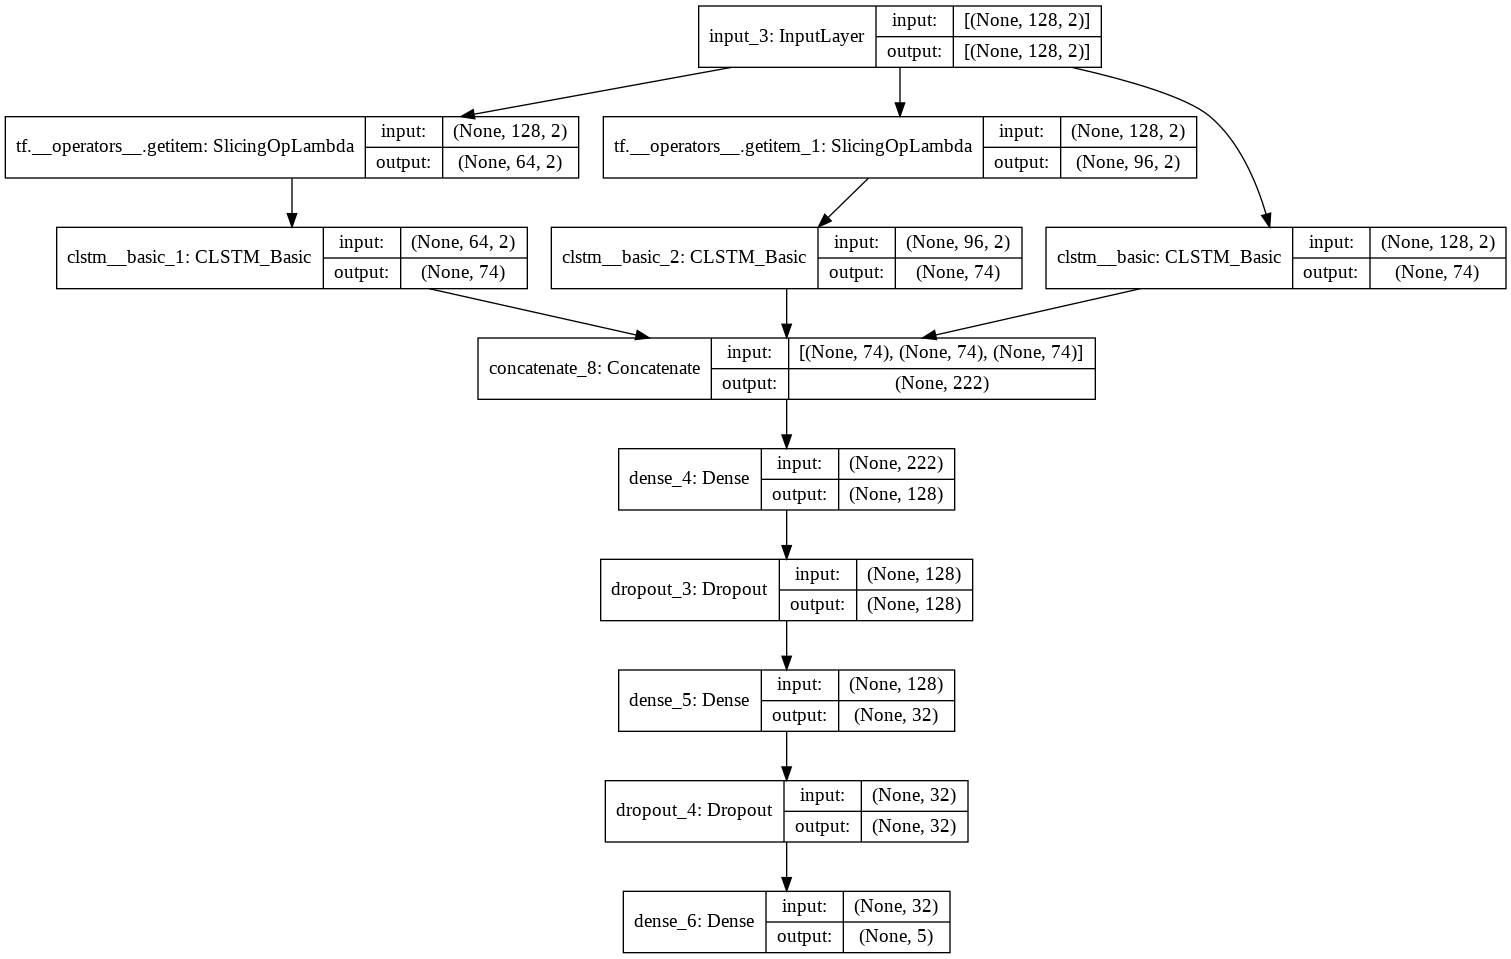

In [ ]:
def CLSTM_with_VTL(): # CLSTM_with_Various_Time_Length
  input = keras.Input(shape = (128,2))

  t1 = CLSTM_Basic(128)(input)
  t2 = CLSTM_Basic(64)(input[:, 64:, :])
  t3 = CLSTM_Basic(32)(input[:, 32:, :])

  y = keras.layers.Concatenate()([t1, t2, t3])
  y = keras.layers.Dense(128, activation = "relu")(y)
  y = keras.layers.Dropout(0.5)(y)
  y = keras.layers.Dense(32, activation = "relu")(y)
  y = keras.layers.Dropout(0.5)(y)
  y = keras.layers.Dense(5, activation = "softmax")(y)

  model = keras.Model(input, y)
  return model

model = CLSTM_with_VTL()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 64, 2)        0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 96, 2)        0           input_3[0][0]                    
__________________________________________________________________________________________________
clstm__basic (CLSTM_Basic)      (None, 74)           40224       input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(Train_Dataset, epochs = 50, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/50
17280/17280 [==============================] - 252s 14ms/step - loss: 0.0677 - accuracy: 0.9796 - val_loss: 0.0218 - val_accuracy: 0.9939
Epoch 2/50
17280/17280 [==============================] - 247s 14ms/step - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.0108 - val_accuracy: 0.9968
Epoch 3/50
17280/17280 [==============================] - 246s 14ms/step - loss: 0.0163 - accuracy: 0.9957 - val_loss: 0.0201 - val_accuracy: 0.9951
Epoch 4/50
17280/17280 [==============================] - 244s 14ms/step - loss: 0.0139 - accuracy: 0.9963 - val_loss: 0.0054 - val_accuracy: 0.9983
Epoch 5/50
17280/17280 [==============================] - 245s 14ms/step - loss: 0.0123 - accuracy: 0.9968 - val_loss: 0.0121 - val_accuracy: 0.9971
Epoch 6/50
17280/17280 [==============================] - 244s 14ms/step - loss: 0.0117 - accuracy: 0.9970 - val_loss: 0.0093 - val_accuracy: 0.9986
Epoch 7/50
17280/17280 [==============================] - 244s 14ms/step - loss: 0.0111 - accuracy: 0.9972

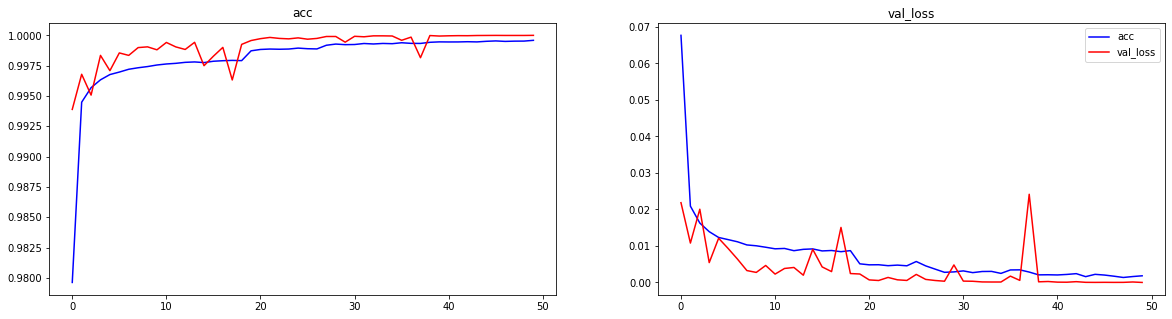

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hist.history['accuracy'], c = 'b')
ax1.plot(hist.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(hist.history['loss'], c = 'b')
ax2.plot(hist.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e8bb1b10>]],
      dtype=object)

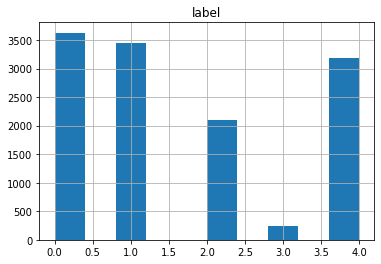

In [ ]:
pred=model.predict(Test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL5.csv', index = False)
sub.hist()